In [1]:
%%time

### importing the library
from __future__ import print_function
import pandas as pd
import numpy as np
import seaborn as sns

from scipy import signal

import matplotlib.pyplot as plt
%matplotlib inline 
import matplotlib.mlab as mlab
import urllib

import time

CPU times: user 1.48 s, sys: 483 ms, total: 1.96 s
Wall time: 4.47 s


In [2]:
%%time

url  = 'https://dcc.ligo.org/public/0002/T0900288/003/ZERO_DET_high_P.txt'
raw_data=urllib.request.urlopen(url)
ZERO_DET = np.loadtxt(raw_data)

CPU times: user 86.5 ms, sys: 14.6 ms, total: 101 ms
Wall time: 2.53 s


In [3]:
def oneSidedPeriodogram(y, fs):
    N = y.size
    yf = np.fft.fft(y)
    xf = np.fft.fftfreq(N, 1./fs)
    oneSidedPeriodogram = 2/fs*abs(yf[xf>=0])**2/N
    return yf, xf[xf>=0], oneSidedPeriodogram


def TimeseriesFromPSD(N = 8192, fs = 8192, fmin = 20, fmax = 4000):
    low_f_max = fmin
    high_f_min = fmax
    # Interpolation
    freqs = np.fft.fftfreq(N, 1./fs)
    asd_zero = np.interp(freqs[(freqs>=ZERO_DET[:,0].min())&(freqs<=high_f_min)], ZERO_DET[:,0], ZERO_DET[:,1]) 
    
    
    # Gauss noise and its one-sided PSD without window
    gauss_noise = 1* np.random.normal(loc=0,scale=64,size=N)
    _, xf_noise, psd_gauss = oneSidedPeriodogram(gauss_noise, fs)
    # psd_gauss ,xf_noise= plt.mlab.psd(gauss_noise, Fs=fs, NFFT=NFFT, window=psd_window, noverlap=NOVL)
    # xf_noise = xf_noise[1:]
    # psd_gauss = psd_gauss[1:]

    # Confirm the range of low frequency
#     shiftsize = 11
#     low_f_max = ZERO_DET[:,0].min() + shiftsize
#     high_f_min = 4000
    shiftsize = int(low_f_max - ZERO_DET[:,0].min())
    slc, slc_, slc__ = (xf_noise >= low_f_max)&(xf_noise<=high_f_min), (xf_noise < low_f_max), (xf_noise > high_f_min)

    # Two-sided PSD
    psd_twosided = np.hstack(( # low positive
                        psd_gauss[slc_] * 0
                       # high positive
                      , psd_gauss[slc][:] * (asd_zero**2)[shiftsize:]
                      , psd_gauss[slc__] * 0
                      , psd_gauss[slc__][::-1] * 0
                       # high negative
                      , psd_gauss[slc][:][::-1] *(asd_zero**2)[shiftsize:][::-1]
                       # low negative
                      , psd_gauss[slc_][::-1] * 0))

    np.random.seed()
    amplitude =  np.sqrt(psd_twosided *2 *fs*N )
    epsilon = np.random.rand(len(amplitude))*1j*2*np.pi
    return np.real(np.fft.ifft(amplitude*np.exp(epsilon))), psd_twosided   

In [4]:
%timeit TimeseriesFromPSD()

8.6 ms ± 704 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [27]:
%%time 

TimeseriesFromPSD()

CPU times: user 4.56 ms, sys: 8.19 ms, total: 12.8 ms
Wall time: 12.7 ms


(array([  1.39918825e-21,  -1.08159257e-21,   1.27712171e-21, ...,
         -1.32878144e-21,   2.48208943e-21,  -1.11784182e-21]),
 array([ 0.,  0.,  0., ...,  0.,  0.,  0.]))

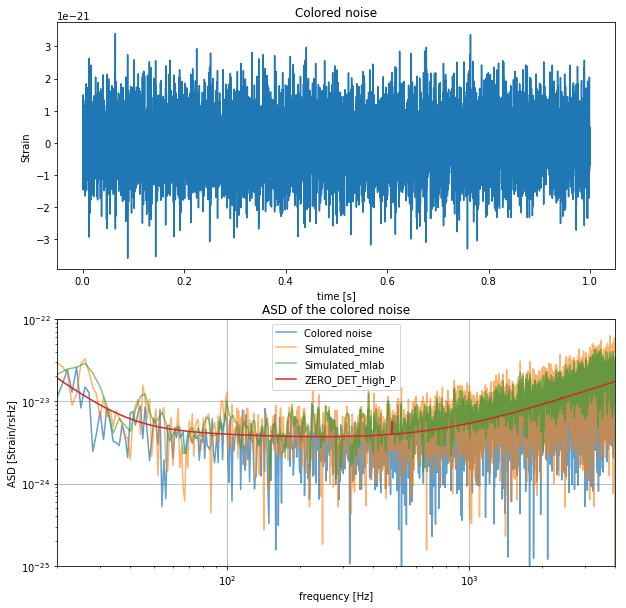

In [5]:
N = 8192
fs = 8192
fmin = 20
fmax = 4000

noise_sample, psd_zero = TimeseriesFromPSD(fmin=fmin, fmax=fmax)

plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.plot(np.linspace(0, N/fs, N), noise_sample)
plt.title('Colored noise')
plt.ylabel('Strain')
plt.xlabel('time [s]')


plt.subplot(2,1,2)
plt.loglog( np.sqrt(psd_zero[1:]), label = "Colored noise", alpha=0.7)

# Check#1
_, xf_noise_sample, PSD_noise_sample = oneSidedPeriodogram(noise_sample, fs)
plt.loglog(xf_noise_sample[1:], np.sqrt(PSD_noise_sample[1:]), label = "Simulated_mine", alpha=0.6)

# Check#2
NFFT = fs//2
# NFFT = 4*fs
psd_window = np.blackman(NFFT)
NOVL = NFFT/2
PSD_noise_sample ,xf_noise_sample= plt.mlab.psd(noise_sample, Fs=fs, NFFT=NFFT, window=psd_window, noverlap=NOVL)

plt.loglog(xf_noise_sample[1:], np.sqrt(PSD_noise_sample[1:]), label = "Simulated_mlab", alpha=0.6)
plt.loglog(ZERO_DET[:,0],ZERO_DET[:,1], label = "ZERO_DET_High_P")
plt.xlim(xmin=fmin, xmax = fmax)
plt.ylim((1e-25, 1e-22))
plt.title('ASD of the colored noise')
plt.ylabel('ASD [Strain/rsHz]')
plt.xlabel('frequency [Hz]')
plt.grid()
plt.legend()
plt.show()